In [1]:
import tensorflow as tf
import numpy as np

In [3]:
class InputProcessLayer(tf.keras.layers.Layer):
    """
    输入处理层
    """
    def __init__(self,emb_input_output_dims,*args,**kwargs):
        """

        :param emb_input_output_dims: [(int, int)] 每一个tuple都对应一个field的稀疏（类别）特征的embedding参数
            例如[(2,4), (5,6)]代表的是：第一个field特征的取值可以有2种（0或者1），该field的嵌入向量维度为4
            第一个field特征的取值可以有5种（0~4），该field的嵌入向量维度为5
            这样做的好处是不同field的嵌入维度可以不同
        :param args:
        :param kwargs:
        """
        super(InputProcessLayer,self).__init__(*args,**kwargs)

        self.emb_layers=list()
        for input_dim,output_dim in emb_input_output_dims:
            self.emb_layers.append(tf.keras.layers.Embedding(input_dim=input_dim,output_dim=output_dim))

    def call(self, inputs, **kwargs):
        """

        :param inputs: one batch of data 两部分组成，shape: ((batch_size, dense_field_num), (batch_size, sparse_field_num))
            dense_inputs,sparse_inputs=inputs
            dense_inputs指的是连续特征
            sparse_inputs指的是类别特征，注意sparse_inputs的field数目应该与self.emb_layers中的embedding layer数目一致，其中sparse_inputs的第i个field对应第i个嵌入层
        :param kwargs:
        :return:
        """
        dense_inputs,sparse_inputs=inputs
        feature_vectors=[dense_inputs]
        for i,emb_layer in enumerate(self.emb_layers):
            feature_vectors.append(emb_layer(sparse_inputs[:,i]))

        return tf.concat(feature_vectors,axis=1)

dense_input_arr=np.random.random(size=[5,3]).astype(np.float32)
sparse_input_arr=np.random.randint(0,3,size=[5,2]).astype(np.float32)
input_arr=(dense_input_arr,sparse_input_arr)
input_process_layer=InputProcessLayer(emb_input_output_dims=[(3,4),(3,5)])
input_process_layer(input_arr)

<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[ 0.89252937,  0.25412723,  0.05097652, -0.03181811, -0.02142682,
         0.02673891, -0.04373182,  0.03213856,  0.00317651,  0.02348049,
        -0.04340848, -0.03600123],
       [ 0.36070046,  0.17560574,  0.7344037 ,  0.02753541, -0.027091  ,
         0.02729161, -0.02852   ,  0.0375202 ,  0.04264841, -0.02920493,
        -0.02852439,  0.04281136],
       [ 0.9018676 ,  0.7967085 ,  0.2212375 , -0.03181811, -0.02142682,
         0.02673891, -0.04373182,  0.02690298, -0.03663285,  0.04976735,
        -0.01455729, -0.00660523],
       [ 0.9270268 ,  0.01525519,  0.54198486,  0.02753541, -0.027091  ,
         0.02729161, -0.02852   ,  0.0375202 ,  0.04264841, -0.02920493,
        -0.02852439,  0.04281136],
       [ 0.7088643 ,  0.12298987,  0.55963516, -0.03181811, -0.02142682,
         0.02673891, -0.04373182,  0.0375202 ,  0.04264841, -0.02920493,
        -0.02852439,  0.04281136]], dtype=float32)>

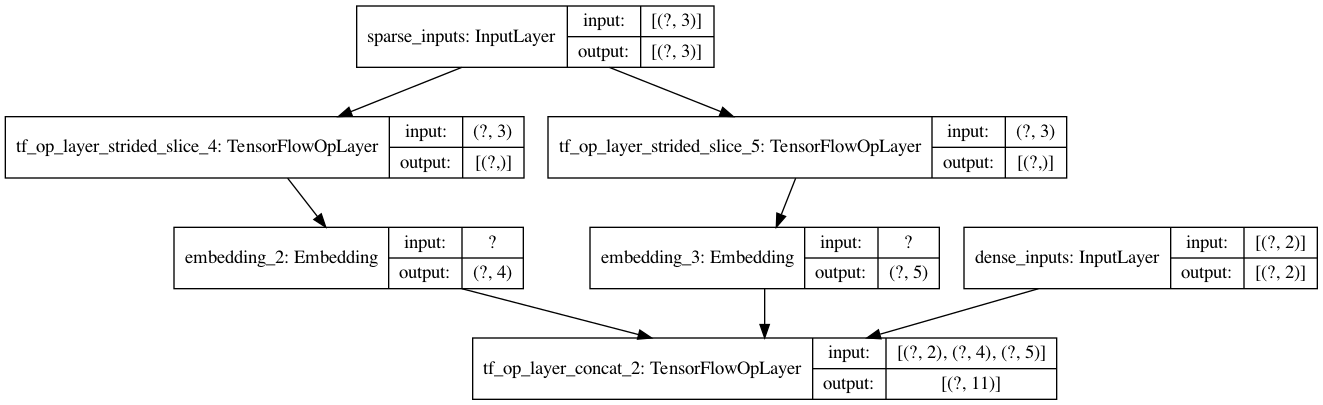

In [10]:
inputs=(tf.keras.Input(shape=(2,), dtype=tf.float32, name='dense_inputs'),tf.keras.Input(shape=(3,), dtype=tf.float32, name='sparse_inputs')) # 里面的shape指的是一个样本的维度
outputs=input_process_layer.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="input_process_layer.png", show_shapes=True,expand_nested=True)


In [14]:
class CrossLayer(tf.keras.layers.Layer):
    """
    cross network
    """
    def __init__(self,L1,*args,**kwargs):
        """

        :param L1: int 即cross network的深度
        :param args:
        :param kwargs:
        """
        super(CrossLayer,self).__init__(*args,**kwargs)
        self.L1=L1

    def build(self, input_shape):
        """
        由于该组件里的每一次计算，输入和输出的shape是相同的，但输入未定的情况下，模型参数无法确定，所以需要使用build方法，在模型call之前自动确定参数的shape
        :param input_shape: [batch_size,emb_feature_dim]
        :return:
        """
        feature_dim=input_shape[1]
        self.ws=list()
        self.biases=list()
        for _ in range(self.L1):
            self.ws.append(tf.Variable(tf.random.truncated_normal(shape=[feature_dim,1])))
            self.biases.append(tf.Variable(tf.zeros(shape=[feature_dim,1])))

    def call(self, inputs, **kwargs):
        x=tf.expand_dims(inputs,axis=2) # [batch_size,emb_feature_dim,1] 这样做是因为cross操作里每个样本的cross都会生成一个新的矩阵，所以扩充维度
        x0=tf.expand_dims(inputs,axis=2) # [batch_size,emb_feature_dim,1]
        for i in range(self.L1):
            weight=self.ws[i]
            bias=self.biases[i]
            x=tf.matmul(tf.matmul(x0,x,transpose_b=True),weight)+x+bias
        return tf.squeeze(x)

input_arr=np.random.random(size=[5,10]).astype(np.float32)
cross_layer=CrossLayer(L1=2)
cross_layer(input_arr)

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[ 1.6925962 ,  1.652268  ,  0.2898696 ,  0.42903993,  0.2816792 ,
         0.94000787,  0.08233929,  0.50784445,  1.5211072 ,  0.02433114],
       [ 0.03210419,  0.3628511 ,  0.73742455,  0.5436165 ,  0.6549914 ,
         0.02537876,  0.49919358,  0.83108646,  0.27625364,  0.8515196 ],
       [ 1.1489276 ,  0.77534276,  0.06324618,  1.0374683 ,  0.6640447 ,
         0.11316389,  0.24497998,  1.0538896 ,  0.5493048 ,  0.5660771 ],
       [ 0.02619512,  0.11495684,  0.48776367,  0.14044175,  0.30551395,
         0.36868346,  0.00750604,  0.10636933,  0.5286126 ,  0.47140247],
       [-0.36891055, -0.05684726, -0.24793774, -0.30485523, -0.5463352 ,
        -0.45914364, -0.23785216, -0.02665836, -0.3907336 , -0.23810834]],
      dtype=float32)>

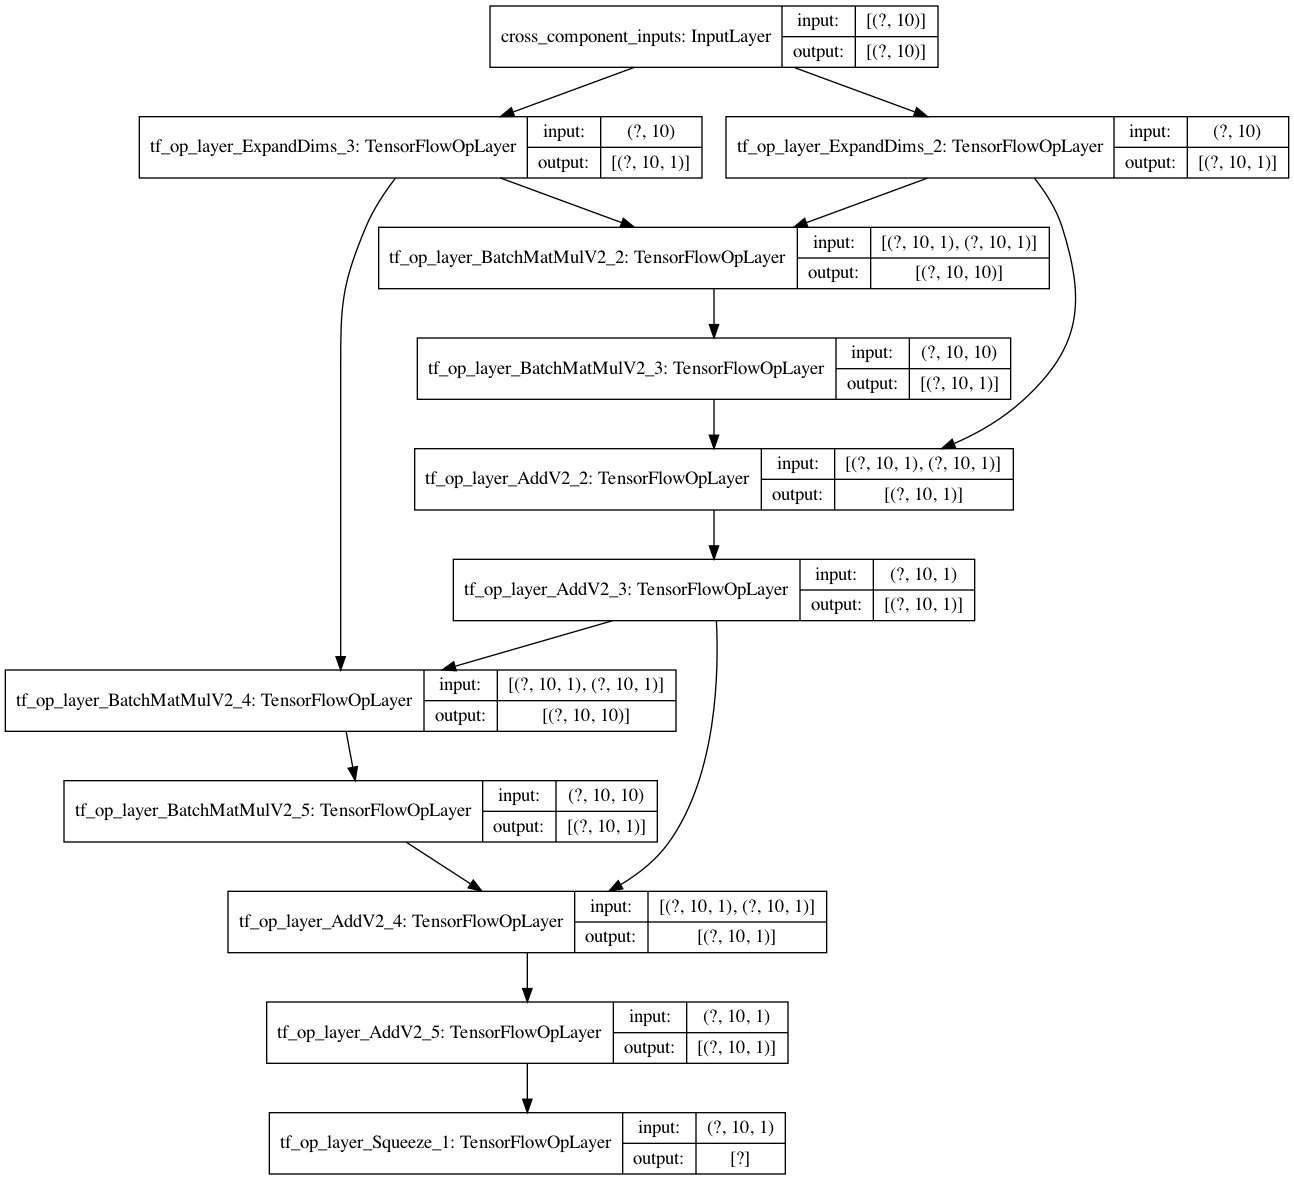

In [15]:
inputs=tf.keras.Input(shape=(10,), dtype=tf.float32, name='cross_component_inputs')
outputs=cross_layer.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="cross_layer.png", show_shapes=True,expand_nested=True)


In [17]:
class DCN(tf.keras.Model):
    def __init__(self,L1,deep_units_list,emb_input_output_dims,scoring_units,*args,**kwargs):
        """
        
        :param L1: int cross部分的深度
        :param deep_units_list: [int] deep部分的神经元数量 
        :param emb_input_output_dims: [(int, int)] 稀疏（类别）特征的输入维度以及嵌入维度
        :param scoring_units: int 最终输出的维度
        :param args: 
        :param kwargs: 
        """
        super(DCN,self).__init__(*args,**kwargs)
        self.L1=L1
        self.dense_layers=list()
        self.input_process_layer=InputProcessLayer(emb_input_output_dims)
        self.cross_layer=CrossLayer(L1=L1)
        for deep_units in deep_units_list:
            self.dense_layers.append(tf.keras.layers.Dense(units=deep_units,activation=tf.nn.relu))
        self.scoring_layer=tf.keras.layers.Dense(units=scoring_units,activation=None)
    def call(self, inputs, training=None, mask=None):
        """
        
        :param inputs: 符合 InputProcessLayer输入的输入
        :param training: 
        :param mask: 
        :return: 
        """
        x0=self.input_process_layer(inputs)
        x_L=self.cross_layer(x0)
        h_L=x0
        for dense_layer in self.dense_layers:
            h_L=dense_layer(h_L)

        x_stack=tf.concat([x_L,h_L],axis=1)
        p=self.scoring_layer(x_stack)

        return p

dense_input_arr=np.random.random(size=[5,3]).astype(np.float32)
sparse_input_arr=np.random.randint(0,3,size=[5,2]).astype(np.float32)
input_arr=(dense_input_arr,sparse_input_arr)
dcn=DCN(L1=2,deep_units_list=[4,4,3],emb_input_output_dims=[(3,4),(3,5)],scoring_units=2)
dcn(input_arr)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.12033884,  0.01361499],
       [-0.01423507,  0.00324822],
       [-0.02080761,  0.01714245],
       [-0.01099073, -0.00231999],
       [-0.02764417,  0.00831715]], dtype=float32)>

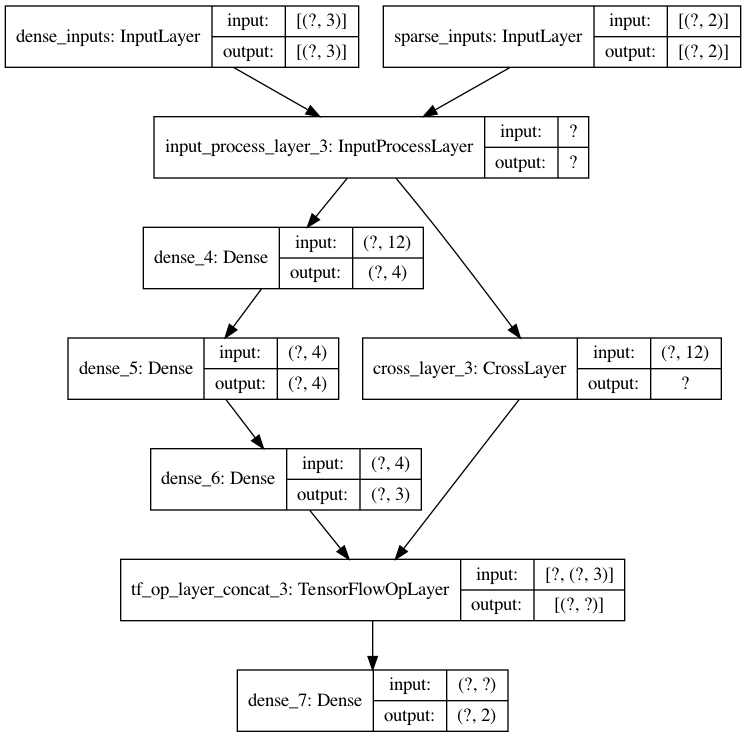

In [22]:
inputs=(tf.keras.Input(shape=(3,), dtype=tf.float32, name='dense_inputs',batch_size=None),tf.keras.Input(shape=(2,), dtype=tf.float32,batch_size=None, name='sparse_inputs'))
outputs=dcn.call(inputs)
dcn_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
tf.keras.utils.plot_model(dcn_for_plot,show_shapes=True,expand_nested=True)
